In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# conda install ipywidgets
# conda install nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Data Processing

In [2]:
# Read in the data
df = pd.read_csv(os.path.join(os.getcwd(), "traffic_data", "train_ML_IOT.csv"))


In [3]:
# Take out ID column
df = df.loc[:, ['DateTime', 'Junction', 'Vehicles']]
# Convert date from string to datetime
df['DateTime'] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")

# Create year, month, date columns
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['date'] = df['DateTime'].dt.day
# Create weekday. Monday is 0, Sunday is 6
df['weekday'] = df['DateTime'].dt.weekday
df.loc[df['weekday']==0,'weekday'] = "Monday"
df.loc[df['weekday']==1,'weekday'] = "Tuesday"
df.loc[df['weekday']==2,'weekday'] = "Wednesday"
df.loc[df['weekday']==3,'weekday'] = "Thursday"
df.loc[df['weekday']==4,'weekday'] = "Friday"
df.loc[df['weekday']==5,'weekday'] = "Saturday"
df.loc[df['weekday']==6,'weekday'] = "Sunday"
# Create hour column
df['hour'] = df['DateTime'].dt.hour


In [4]:
# Divide into different traffic junctions
df1 = df.loc[df["Junction"]==1, :]
df2 = df.loc[df["Junction"]==2, :]
df3 = df.loc[df["Junction"]==3, :]
df4 = df.loc[df["Junction"]==4, :]

print("Junction 1:", df1.shape, "; Junction 2:", df2.shape, "; Junction 3:", df3.shape, "; Junction 4:", df4.shape)

Junction 1: (14592, 8) ; Junction 2: (14592, 8) ; Junction 3: (14592, 8) ; Junction 4: (4344, 8)


# Visualizations

Our data ranges from November 2015 - June 2017

1) It won't be accurate to compare sums of vehicles for each time period because some periods have more occurrences than other periods. For example, there are 2 Februaries (2016 and 2017) vs. 1 July (2016). Thus, it would be best to compare average number of vehicles.

2) Each row of the data is number of vehicles in an hour, to do analysis, we need to sum up the number of vehicles for each category, and then take the average. For example, sum up the number of vehicles for each month-year combination (i.e. Nov-2015 and Nov-2016), then take the average num of vehicles for each month (i.e. average num of vehicles for November)

In [5]:
# Combine all junctions for visualization later
list_of_dfs = [df1,df2,df3,df4]

### Number of Vehicles per Hour for 3 years

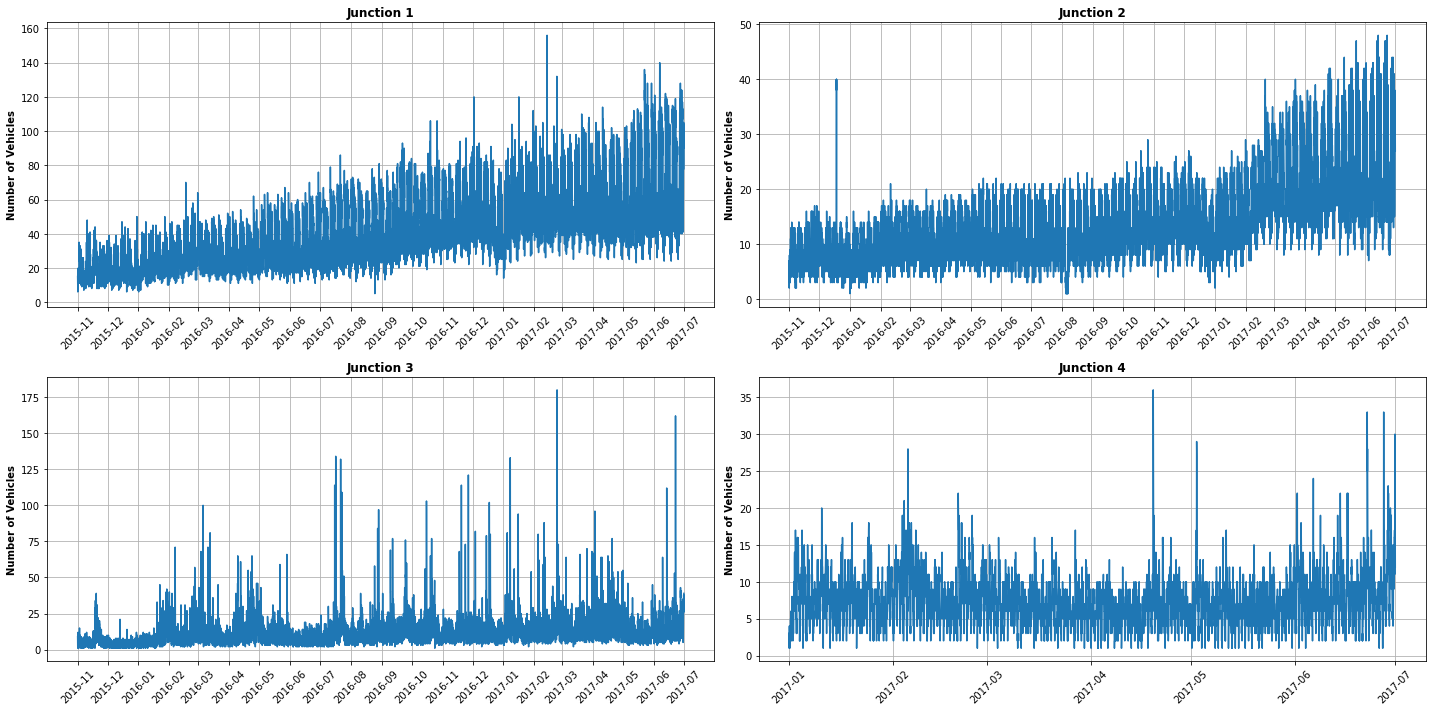

In [6]:
def plot_vehicles_per_hour():
    # Divide into 4 subplots because we have 4 junctions
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    # Group the axes and list of dfs together. Each ax is for each junction
    axes = [ax1, ax2, ax3, ax4]
    list_dfs_axes = list(zip(list_of_dfs, axes))
    
    # initialize i to add to the title
    i=1
    # Loop thru each ax and junction
    for df, ax in list_dfs_axes:
        # plot date vs total number of vehicles 
        ax.plot(df['DateTime'], df['Vehicles'])
        
        # plot a tick every month in the yyyy-mm format
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

        ax.set_title('Junction '+str(i), fontweight='bold')
        ax.set_ylabel('Number of Vehicles', fontweight='bold')
        ax.grid()
        
        # Need to rotate xaxis so all dates will show
        # Have to do plt.sca because without it, only the last plot will be rotated
        plt.sca(ax)
        plt.xticks(rotation=45)
        i+=1
    # Some labels and titles overlap in subplot so we do tightlayout to avoid that
    plt.tight_layout()
        
plot_vehicles_per_hour()

Plot shows number of vehicles that pass by each junction every hour from Nov 2015 - Jun 2017. 
* Here, we see that Junction 1 and Junction 2 have similar patterns; both volumes have increased over the years (increased trend) and their variance have also increased. However, Junction 1 had more vehicles than Junction 2 overall. Thus, traffic at Junction 1 and 2 may have gotten particularly worse over the years.
* Junction 3 shows a slight upward trend and increased variance. 
* Junction 4 seems like it's mostly constant variance and trend. Although, there seems to be less data for Junction 4 (ranges from Jan 17 to July 17)


### Average Number of Vehicles by different categories

In [7]:
# Average number of vehicles that pass thru junction per month, date, or weekday
def plot_avg_vehicles_by_cate(cate_col):
    # Divide into 4 subplots because we have 4 junctions
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(20,10))
    # Group the axes and list of dfs together. Each ax is for each junction
    axes = [ax1, ax2, ax3, ax4]
    list_dfs_axes = list(zip(list_of_dfs, axes))
    
    # Set a list of categories in order from broadest to more specific for groupby
    list_cate = ['year','month','date','weekday']
    
    # initialize i to add to the title
    i=1
    # Loop thru each ax and junction
    for df, ax in list_dfs_axes:
        # Get index of where cate_col is located in list_cate, get all the columns before and including cate_col, and
        # groupby those columns. Sum up the number of vehicles.
        gb1_cols = list_cate[:list_cate.index(cate_col) + 1]
        gb1 = df.groupby(by=gb1_cols, as_index=False).sum()
        # Now, we have the total num of vehicles per category
        # Take average number of vehicles for each level of that category
        gb2 = gb1.groupby(by=[cate_col], as_index=False).mean()
        # Plot category vs. average num of vehicles
        ax.plot(gb2[cate_col], gb2['Vehicles'])
        ax.grid()
        # Ticks is list of values in category
        ax.set_xticks(ticks=gb2[cate_col])  
        ax.set_title('Junction '+str(i), fontweight='bold')
        ax.set_xlabel(cate_col, fontweight='bold')
        ax.set_ylabel('Average Num. of Vehicles', fontweight='bold')
        i+=1
    

In [8]:
interact(plot_avg_vehicles_by_cate, cate_col=['weekday','date','month']);

interactive(children=(Dropdown(description='cate_col', options=('weekday', 'date', 'month'), value='weekday'),…

Looking at average number of vehicles per...
* Weekday: We see that for Junction 1, there's a large difference in volume between Saturday and Sunday vs other days of the week. Compared to Junction 1, other junctions don't exhibit as large of a change, only slight changes. This pattern is probably due to people <b>driving to work</b>.
* Date: Not much patterns are here. There are some increase and decrease, but this is probably due to weekdays intead of actual dates of the month
* Month: We see that there's a large dip in July and August, especially in Junction 1, but also in Junction2. This may be due to <b>school being out</b> in the summer. Junction 3 has peaks in April, September, and October.

From these plots, we can conclude that Junction 1 is a <b>main road</b> that people often take to school or work due to its higher volume, and large fluctuations during weekdays and months. Junction 2, 3, and 4 exhibit similar behavior but not as drastic.

In [9]:
# # Average number of vehicles that pass thru junction per month
# gb1 = df1.groupby(by=["year",'month'], as_index=False).sum()
# gb1.groupby(by=["month"], as_index=False).mean()
# # Average number of vehicles that pass thru junction per date/weekday
# gb1 = df1.groupby(by=["year",'month','date','weekday'], as_index=False).sum()
# gb1.groupby(by=["date"], as_index=False).mean()

### Average Number of Vehicles per Hour by different categories

In [10]:
# Average number of vehicles per hour by weekday, month, or year
def plot_avg_vehicles_per_hour_by_cate(cate_col):
    # Divide into 4 subplots because we have 4 junctions
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20,10))
    # Group the axes and list of dfs together. Each ax is for each junction
    axes = [ax1, ax2, ax3, ax4]
    list_dfs_axes = list(zip(list_of_dfs, axes))
    
    
    # initialize i to add to the title
    i=1
    # Loop thru each ax and junction
    for df, ax in list_dfs_axes:
        if cate_col == None:
            gb1 = df.groupby(by=['hour'], as_index=False).mean()
            ax.plot(gb1['hour'], gb1['Vehicles'])
            ax.grid()
            # Ticks is the list of hours
            ax.set_xticks(ticks=gb1['hour'])
            ax.set_title('Junction '+str(i), fontweight='bold')
            ax.set_xlabel('Hour of the Day', fontweight='bold')
            ax.set_ylabel('Average Num. of Vehicles per Hour', fontweight='bold')
        else:
            # Group by the indicated category (year, month, weekday) and hour, averaging the num of vehicles
            gb1 = df.groupby(by=[cate_col,'hour'], as_index=False).mean()

            # For each category, plot the hours in that category vs. average num of vehicles
            for item in gb1[cate_col].unique():
                # Filter out the category
                df_plot = gb1.loc[gb1[cate_col] == item, :]
                # Plot hours vs average num of vehicles
                ax.plot(df_plot['hour'], df_plot['Vehicles'], label=item)
                ax.grid()
                # Ticks is the list of hours
                ax.set_xticks(ticks=df_plot['hour'])
                ax.set_title('Junction '+str(i), fontweight='bold')
                ax.set_xlabel('Hour of the Day', fontweight='bold')
                ax.set_ylabel('Average Num. of Vehicles per Hour', fontweight='bold')
                ax.legend()
        i+=1

In [11]:
interact(plot_avg_vehicles_per_hour_by_cate, cate_col=['year','month','weekday', None]);

interactive(children=(Dropdown(description='cate_col', options=('year', 'month', 'weekday', None), value='year…

Looking at average number of vehicles per hour, broken down into...
* Weekday: We see that for Junction 1, there's a large increase at the 9th hour. There's also significantly more vehicles on weekdays vs Saturday and Sunday. This is probably due to <b>work traffic</b>. Other junctions exhibit similar behavior, but the variation is not as drastic. There's also a large increase in Junction 3 on Saturday at the 20th hour. This may be because Junction 3 is used to travel to areas with many <b>weekend activities</b>.
* Year: For Junction 1,2,3, there has been an increase in traffic over the years. But the <b>pattern of hourly traffic remain the same</b> for each junction.
* None: Here, we don't break down by any category. We see that Junction 1 has high fluctuations in traffic throughout the day compared to Junctions 2,3, and 4. However, the shape of the traffic volume is similar for the 4 junctions.
* Month: We see that May and June are Junction 1 and 2's highest traffic months. While Junction 3's highest is April. Thus, Junction 3 may be used to travel in different ways than how Junction 1 and 2 are used. There's likely not enough data for Junction 4 to see big differences among the months.

In [18]:
# # Average number of vehicles per hour by weekday
# gb = df1.groupby(by=['weekday','hour'], as_index=False).mean()